In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import signal
from torch.utils.tensorboard import SummaryWriter

In [2]:
# default `log_dir` is "runs" 
writer = SummaryWriter('runs/Trading_bot')

In [3]:
goog = pd.read_csv('GOOG.csv')

In [4]:
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400
...,...,...,...,...,...,...,...
1756,2017-08-03,949.099976,950.000000,939.440002,940.299988,940.299988,1123900
1757,2017-08-04,943.950012,947.539978,939.799988,945.789978,945.789978,1254600
1758,2017-08-07,947.520020,948.960022,943.500000,945.750000,945.750000,1445800
1759,2017-08-08,944.289978,952.489990,942.479980,944.190002,944.190002,1505100


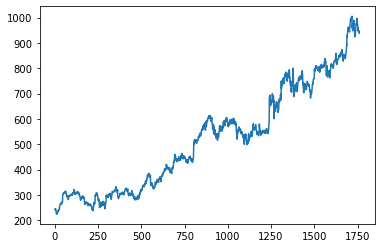

In [5]:
plt.plot(range(0, len(goog.Open)), goog.Open)

In [6]:
aapl = pd.read_csv('AAPL.csv')

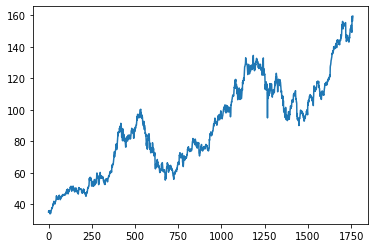

In [7]:
plt.plot(range(0, len(aapl.Open)), aapl.Open)

In [8]:
class TradingEnvironment():
   
    def __init__(self, data_open = goog.Open, data_close = goog.Close, data2_open = aapl.Open, data2_close = aapl.Close, max_stride=5, series_length=200, starting_point=0):
        
        self.data_open = data_open
        self.data_close = data_close
        self.data2_open = aapl.Open
        self.data2_close = aapl.Close
        #Observation space [No.of shares, Cash in hand, next opening price, portfolio value, past 5 day average]
        self.state = torch.FloatTensor(torch.zeros(8))
        #Starting cash
        self.starting_cash = 6000
        #Length of time series
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        #Initial No.of shares stock1
        self.state[0] = 20
        #Initial No.of shares stock2
        self.state[1] = 20
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        #current Opening price -goog
        self.state[3] = self.data_open[self.cur_timestep]
        #current Opening price -aapl
        self.state[4] = self.data2_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        #5 day average price -goog
        self.state[6] = self.five_day_window()[0]
        #5 day average price -aapl
        self.state[7] = self.five_day_window()[1]
        #Inventory holds the price of bought goog stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
        
         #Inventory holds the price of bought aapl stock
        self.inventory_aapl = []
        num = int(self.state[1].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory_aapl.append(self.data2_open[self.cur_timestep])

        self.stride = max_stride
        self.done = False
        self.profit = 0
    
    def portfolio_value(self):#To calculate total portfolio value
        return ((self.state[0] * self.data_close[self.cur_timestep]) + (self.state[1] * self.data2_close[self.cur_timestep]) + self.state[2])
   
    def next_opening_price(self):#Finding the next opening price
        step = self.cur_timestep + self.stride
        return [self.data_open[step], self.data2_open[step]]
    
    def five_day_window(self):#past Five day average calc
        step = self.cur_timestep
        if step < 5:
            return [self.data_open[0],self.data2_open[0]]
        goog5 = self.data_open[step-5:step].mean()
        apl5 = self.data2_open[step-5:step].mean()
        return [goog5, apl5]

    
    def step(self, action):
        delta1 = 0
        delta2 = 0
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        cur_ts = (cur_timestep / self.stride - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        
        #Check if done
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1],  self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
            self.state = new_state
            if self.profit > 0:
                rew = 1
            else:
                rew = 0
            return new_state, rew, True, { "msg": "done"}
        #action ==2 ,Do nothing return the next state
        if action[0] == 2:
            new_state = [self.state[0], self.state[1],  self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, 0, False, { "msg": "nothing" }
             
        #Action = 0, Buy goog, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 0:
            if action[1] * self.data_open[cur_timestep] < self.state[2]:
                goog_shares = self.state[0] + action[1]
                cash_spent = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1], self.state[2]- cash_spent, *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory[-1]
                delt = prev_price - self.data_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory.append(self.data_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought goog"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 1: #Action = 1, Sell goog, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[0]:
                goog_shares = self.state[0] - action[1]
                cash_gained = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), cur_value, *self.five_day_window()]
                bought_price = self.inventory.pop(0)
                delta1 = self.data_open[cur_timestep] - bought_price
                self.state = new_state
                if delta1 > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold goog"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        
               
        #Action = 0, Buy aapl, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 3:
            if action[1] * self.data2_open[cur_timestep] < self.state[2]:
                aapl_shares = self.state[1] + action[1]
                cash_spent = action[1] * self.data2_open[cur_timestep]
                new_state = [self.state[0], aapl_shares, self.state[2]- cash_spent, *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory_aapl[-1]
                delt = prev_price - self.data2_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory_aapl.append(self.data2_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought aapl"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 4: #Action = 1, Sell goog, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[1]:
                aapl_shares = self.state[1] - action[1]
                cash_gained = action[1] * self.data2_open[cur_timestep]
                new_state = [self.state[0], aapl_shares, self.state[2] + cash_gained, *self.next_opening_price(), cur_value, *self.five_day_window()]
                bought_price = self.inventory_aapl.pop(0)
                delta2 = self.data2_open[cur_timestep] - bought_price
                self.state = new_state
                if delta2 > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold aapl"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        
                
        #Calculate selling profit      
        self.profit += (delta1 + delta2)
        #Increase step
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):#Reset observation space and timestep
        self.state = torch.FloatTensor(torch.zeros(8))
        self.starting_cash = 6000
        self.cur_timestep = self.starting_point
        #Initial No.of shares stock1
        self.state[0] = 20
        #Initial No.of shares stock2
        self.state[1] = 20
        self.state[2] = self.starting_cash
        #current Opening price -goog
        self.state[3] = self.data_open[self.cur_timestep]
        #current Opening price -aapl
        self.state[4] = self.data2_open[self.cur_timestep]
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        #5 day average price -goog
        self.state[6] = self.five_day_window()[0]
        #5 day average price -aapl
        self.state[7] = self.five_day_window()[1]
        #Inventory holds the price of bought goog stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
         #Inventory holds the price of bought aapl stock
        self.inventory_aapl = []
        num = int(self.state[1].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory_aapl.append(self.data2_open[self.cur_timestep])
        self.done = False   
        self.profit = 0
        return self.state

In [9]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 32)
        self.hidden_2 = nn.Linear(32,31)
        #Actor Layer
        self.action_head = nn.Linear(31, 5)
        #Critic Layer
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        #Get an action
        action = m.sample()
        #If action is sell and no.of share is zero, force it to do nothing
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [12]:
#Define Environment, Agent, optimizer
env = TradingEnvironment(data_open = goog.Open, data_close = goog.Close,data2_open = aapl.Open, data2_close = aapl.Close, max_stride=1, series_length= len(goog.Open)-2)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [13]:
env.reset()
gamma = 0.988
#Log every 50 episode
log_interval = 50

#At the end of each episode update gardients
def finish_episode(episode):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []
    #Calculate discounted reward
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    #Standardize the discounted reward (Helps converge faster)
    eps = np.finfo(np.float32).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)
    #Calculate policy and value loss  
    for (log_prob, value), R in zip(saved_actions, returns):
        #Calculate advantage value
        advantage = torch.tensor(R - value.item())
        policy_losses.append(-log_prob * advantage)
        #Smooth L1 loss has the advantage of both L1 and L2 loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    #Reset gradients           
    optimizer.zero_grad()
    #Sum up policy and value losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    writer.add_scalar('Policy loss',torch.stack(policy_losses).sum(), episode)
    writer.add_scalar('Value loss',torch.stack(value_losses).sum(), episode)
    writer.add_scalar('Total loss',loss, episode)
    #Backpropogation
    loss.backward()
    optimizer.step()    
    #Delete saved rewards and actions
    del model.rewards[:]
    del model.saved_actions[:]

In [14]:
#Start training
running_reward = 0
#Train for 1000 episodes
for episode in range(0,2000):
    state = env.reset()
    done = False
    msg = None
    ep_rew = 0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        #print(action,state,reward)
        model.rewards.append(reward)
        ep_rew += reward
        if done:
            break
    finish_episode(episode)
    running_reward = running_reward * (1 - 0.05) + ep_rew * (0.05)
     # ...log the running reward
    writer.add_scalar('Running reward',running_reward,episode)
    #stop training if the threshold is reached
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and reward == 1 and running_reward > 950:
        print("Early Stopping--- Profit :" + str(int(env.profit)))
        break
    #Log every 10 episodes
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, last reward {} \
episode reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, ep_rew, running_reward))

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 11644.4, finished at 14060.8 because Bankrupt @ t=361, last reward 0 episode reward 152.0, running reward 7.6
Episode 50: started at 11644.4, finished at 12596.0 because Sold more than have @ t=339, last reward 0 episode reward 158.0, running reward 291.0
Episode 100: started at 11644.4, finished at 18458.9 because Sold more than have @ t=1216, last reward 0 episode reward 601.0, running reward 385.1
Episode 150: started at 11644.4, finished at 12725.0 because Sold more than have @ t=94, last reward 0 episode reward 43.0, running reward 439.2
Episode 200: started at 11644.4, finished at 17458.7 because Sold more than have @ t=713, last reward 0 episode reward 386.0, running reward 636.3
Episode 250: started at 11644.4, finished at 21127.3 because Sold more than have @ t=1313, last reward 0 episode reward 707.0, running reward 726.8
Episode 300: started at 11644.4, finished at 28681.4 because done @ t=1759, last reward 1 episode reward 996.0, running reward 735.3
E

In [15]:
#Check out a sample run
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} goog, have {} appl, ${} cash ".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 11644.4248046875
bought aapl, have 20.0 goog, have 21.0 appl, $5964.7587890625 cash 
sold aapl, have 20.0 goog, have 20.0 appl, $6000.708984375 cash 
sold aapl, have 20.0 goog, have 19.0 appl, $6036.07763671875 cash 
bought goog, have 21.0 goog, have 19.0 appl, $5791.568359375 cash 
bought aapl, have 21.0 goog, have 20.0 appl, $5755.51708984375 cash 
bought aapl, have 21.0 goog, have 21.0 appl, $5719.39697265625 cash 
bought aapl, have 21.0 goog, have 22.0 appl, $5683.77001953125 cash 
bought aapl, have 21.0 goog, have 23.0 appl, $5647.7998046875 cash 
sold aapl, have 21.0 goog, have 22.0 appl, $5682.466796875 cash 
bought goog, have 22.0 goog, have 22.0 appl, $5457.24169921875 cash 
sold aapl, have 22.0 goog, have 21.0 appl, $5492.30615234375 cash 
sold aapl, have 22.0 goog, have 20.0 appl, $5526.841796875 cash 
bought aapl, have 22.0 goog, have 21.0 appl, $5492.447265625 cash 
bought aapl, have 22.0 goog, have 22.0 appl, $5457.8974609375 cash 
bought goog, ha

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


bought aapl, have 34.0 goog, have 26.0 appl, $1885.0867919921875 cash 
sold aapl, have 34.0 goog, have 25.0 appl, $1928.898193359375 cash 
sold aapl, have 34.0 goog, have 24.0 appl, $1973.2481689453125 cash 
bought aapl, have 34.0 goog, have 25.0 appl, $1928.6767578125 cash 
sold aapl, have 34.0 goog, have 24.0 appl, $1973.4967041015625 cash 
sold goog, have 33.0 goog, have 24.0 appl, $2268.37646484375 cash 
sold aapl, have 33.0 goog, have 23.0 appl, $2313.16796875 cash 
bought aapl, have 33.0 goog, have 24.0 appl, $2268.12939453125 cash 
sold goog, have 32.0 goog, have 24.0 appl, $2552.744140625 cash 
nothing, have 32.0 goog, have 24.0 appl, $2552.744140625 cash 
sold aapl, have 32.0 goog, have 23.0 appl, $2598.26416015625 cash 
sold aapl, have 32.0 goog, have 22.0 appl, $2644.521240234375 cash 
sold goog, have 31.0 goog, have 22.0 appl, $2940.802490234375 cash 
sold goog, have 30.0 goog, have 22.0 appl, $3238.039794921875 cash 
sold aapl, have 30.0 goog, have 21.0 appl, $3283.7041015

bought goog, have 24.0 goog, have 35.0 appl, $4310.8623046875 cash 
bought goog, have 25.0 goog, have 35.0 appl, $4057.51904296875 cash 
bought goog, have 26.0 goog, have 35.0 appl, $3814.7763671875 cash 
sold goog, have 25.0 goog, have 35.0 appl, $4058.615234375 cash 
bought aapl, have 25.0 goog, have 36.0 appl, $4012.163818359375 cash 
sold goog, have 24.0 goog, have 36.0 appl, $4253.47021484375 cash 
bought aapl, have 24.0 goog, have 37.0 appl, $4206.1318359375 cash 
bought aapl, have 24.0 goog, have 38.0 appl, $4159.33349609375 cash 
sold aapl, have 24.0 goog, have 37.0 appl, $4206.99755859375 cash 
bought goog, have 25.0 goog, have 37.0 appl, $3958.47900390625 cash 
sold goog, have 24.0 goog, have 37.0 appl, $4209.72509765625 cash 
sold aapl, have 24.0 goog, have 36.0 appl, $4257.7177734375 cash 
sold goog, have 23.0 goog, have 36.0 appl, $4520.630859375 cash 
bought aapl, have 23.0 goog, have 37.0 appl, $4470.78076171875 cash 
sold goog, have 22.0 goog, have 37.0 appl, $4741.5517

bought aapl, have 24.0 goog, have 43.0 appl, $3719.03857421875 cash 
sold goog, have 23.0 goog, have 43.0 appl, $4051.886474609375 cash 
sold goog, have 22.0 goog, have 43.0 appl, $4383.28271484375 cash 
bought aapl, have 22.0 goog, have 44.0 appl, $4323.3154296875 cash 
bought goog, have 23.0 goog, have 44.0 appl, $3999.741943359375 cash 
sold goog, have 22.0 goog, have 44.0 appl, $4314.93212890625 cash 
bought aapl, have 22.0 goog, have 45.0 appl, $4254.54931640625 cash 
sold goog, have 21.0 goog, have 45.0 appl, $4570.47509765625 cash 
bought aapl, have 21.0 goog, have 46.0 appl, $4510.51806640625 cash 
sold goog, have 20.0 goog, have 46.0 appl, $4826.82421875 cash 
bought aapl, have 20.0 goog, have 47.0 appl, $4765.830078125 cash 
sold goog, have 19.0 goog, have 47.0 appl, $5086.64599609375 cash 
bought aapl, have 19.0 goog, have 48.0 appl, $5025.576171875 cash 
sold aapl, have 19.0 goog, have 47.0 appl, $5085.95751953125 cash 
bought aapl, have 19.0 goog, have 48.0 appl, $5025.229

bought goog, have 18.0 goog, have 55.0 appl, $4891.94287109375 cash 
bought goog, have 19.0 goog, have 55.0 appl, $4557.9189453125 cash 
bought goog, have 20.0 goog, have 55.0 appl, $4220.4462890625 cash 
sold goog, have 19.0 goog, have 55.0 appl, $4558.58447265625 cash 
bought aapl, have 19.0 goog, have 56.0 appl, $4461.44287109375 cash 
sold aapl, have 19.0 goog, have 55.0 appl, $4557.86865234375 cash 
bought goog, have 20.0 goog, have 55.0 appl, $4218.8447265625 cash 
sold aapl, have 20.0 goog, have 54.0 appl, $4314.650390625 cash 
bought aapl, have 20.0 goog, have 55.0 appl, $4219.3291015625 cash 
sold goog, have 19.0 goog, have 55.0 appl, $4561.94677734375 cash 
sold aapl, have 19.0 goog, have 54.0 appl, $4658.45654296875 cash 
sold goog, have 18.0 goog, have 54.0 appl, $5001.77978515625 cash 
bought goog, have 19.0 goog, have 54.0 appl, $4651.4296875 cash 
sold aapl, have 19.0 goog, have 53.0 appl, $4748.63671875 cash 
sold goog, have 18.0 goog, have 53.0 appl, $5097.9658203125 c

sold aapl, have 21.0 goog, have 54.0 appl, $4207.79931640625 cash 
sold goog, have 20.0 goog, have 54.0 appl, $4614.9365234375 cash 
sold aapl, have 20.0 goog, have 53.0 appl, $4676.90234375 cash 
sold goog, have 19.0 goog, have 53.0 appl, $5070.32568359375 cash 
sold goog, have 18.0 goog, have 53.0 appl, $5460.09033203125 cash 
bought aapl, have 18.0 goog, have 54.0 appl, $5399.181640625 cash 
bought aapl, have 18.0 goog, have 55.0 appl, $5338.0244140625 cash 
sold goog, have 17.0 goog, have 55.0 appl, $5734.861328125 cash 
sold goog, have 16.0 goog, have 55.0 appl, $6131.2529296875 cash 
sold aapl, have 16.0 goog, have 54.0 appl, $6192.2529296875 cash 
bought aapl, have 16.0 goog, have 55.0 appl, $6132.02880859375 cash 
bought goog, have 17.0 goog, have 55.0 appl, $5738.26025390625 cash 
sold aapl, have 17.0 goog, have 54.0 appl, $5796.1162109375 cash 
sold aapl, have 17.0 goog, have 53.0 appl, $5851.54052734375 cash 
sold goog, have 16.0 goog, have 53.0 appl, $6252.2412109375 cash 


sold goog, have 18.0 goog, have 63.0 appl, $4962.3330078125 cash 
sold aapl, have 18.0 goog, have 62.0 appl, $5036.77587890625 cash 
sold goog, have 17.0 goog, have 62.0 appl, $5547.46142578125 cash 
bought goog, have 18.0 goog, have 62.0 appl, $5034.14794921875 cash 
bought aapl, have 18.0 goog, have 63.0 appl, $4959.92236328125 cash 
sold goog, have 17.0 goog, have 63.0 appl, $5464.80224609375 cash 
sold aapl, have 17.0 goog, have 62.0 appl, $5539.08642578125 cash 
bought goog, have 18.0 goog, have 62.0 appl, $5034.73193359375 cash 
sold goog, have 17.0 goog, have 62.0 appl, $5538.61083984375 cash 
sold aapl, have 17.0 goog, have 61.0 appl, $5613.2978515625 cash 
bought goog, have 18.0 goog, have 61.0 appl, $5095.3447265625 cash 
sold goog, have 17.0 goog, have 61.0 appl, $5613.73828125 cash 
sold goog, have 16.0 goog, have 61.0 appl, $6130.11474609375 cash 
sold aapl, have 16.0 goog, have 60.0 appl, $6204.29052734375 cash 
bought aapl, have 16.0 goog, have 61.0 appl, $6130.34765625 

sold aapl, have 15.0 goog, have 60.0 appl, $6819.9658203125 cash 
sold goog, have 14.0 goog, have 60.0 appl, $7351.8056640625 cash 
sold aapl, have 14.0 goog, have 59.0 appl, $7436.376953125 cash 
bought aapl, have 14.0 goog, have 60.0 appl, $7351.744140625 cash 
sold goog, have 13.0 goog, have 60.0 appl, $7884.88427734375 cash 
sold goog, have 12.0 goog, have 60.0 appl, $8414.484375 cash 
sold goog, have 11.0 goog, have 60.0 appl, $8943.3642578125 cash 
bought aapl, have 11.0 goog, have 61.0 appl, $8857.005859375 cash 
sold aapl, have 11.0 goog, have 60.0 appl, $8943.267578125 cash 
sold aapl, have 11.0 goog, have 59.0 appl, $9029.9248046875 cash 
sold goog, have 10.0 goog, have 59.0 appl, $9588.0546875 cash 
sold aapl, have 10.0 goog, have 58.0 appl, $9676.037109375 cash 
bought goog, have 11.0 goog, have 58.0 appl, $9101.466796875 cash 
sold aapl, have 11.0 goog, have 57.0 appl, $9191.1591796875 cash 
bought goog, have 12.0 goog, have 57.0 appl, $8619.51953125 cash 
sold goog, have 

bought goog, have 23.0 goog, have 54.0 appl, $2927.96142578125 cash 
bought goog, have 24.0 goog, have 54.0 appl, $2407.3515625 cash 
sold goog, have 23.0 goog, have 54.0 appl, $2941.861572265625 cash 
sold aapl, have 23.0 goog, have 53.0 appl, $3054.441650390625 cash 
bought goog, have 24.0 goog, have 53.0 appl, $2517.51171875 cash 
sold aapl, have 24.0 goog, have 52.0 appl, $2631.3017578125 cash 
sold aapl, have 24.0 goog, have 51.0 appl, $2744.941650390625 cash 
sold goog, have 23.0 goog, have 51.0 appl, $3282.681640625 cash 
sold aapl, have 23.0 goog, have 50.0 appl, $3394.071533203125 cash 
sold goog, have 22.0 goog, have 50.0 appl, $3921.2216796875 cash 
sold goog, have 21.0 goog, have 50.0 appl, $4441.7216796875 cash 
bought aapl, have 21.0 goog, have 51.0 appl, $4334.521484375 cash 
sold goog, have 20.0 goog, have 51.0 appl, $4836.03125 cash 
bought aapl, have 20.0 goog, have 52.0 appl, $4723.361328125 cash 
bought aapl, have 20.0 goog, have 53.0 appl, $4610.76123046875 cash 
s

sold aapl, have 13.0 goog, have 64.0 appl, $6960.5419921875 cash 
bought goog, have 14.0 goog, have 64.0 appl, $6404.02197265625 cash 
sold goog, have 13.0 goog, have 64.0 appl, $6963.43212890625 cash 
bought aapl, have 13.0 goog, have 65.0 appl, $6835.9521484375 cash 
bought aapl, have 13.0 goog, have 66.0 appl, $6708.7421875 cash 
bought aapl, have 13.0 goog, have 67.0 appl, $6579.88232421875 cash 
bought goog, have 14.0 goog, have 67.0 appl, $6020.17236328125 cash 
sold aapl, have 14.0 goog, have 66.0 appl, $6145.63232421875 cash 
sold aapl, have 14.0 goog, have 65.0 appl, $6271.2021484375 cash 
sold goog, have 13.0 goog, have 65.0 appl, $6814.8623046875 cash 
bought goog, have 14.0 goog, have 65.0 appl, $6270.1220703125 cash 
sold aapl, have 14.0 goog, have 64.0 appl, $6395.06201171875 cash 
sold aapl, have 14.0 goog, have 63.0 appl, $6520.9521484375 cash 
sold aapl, have 14.0 goog, have 62.0 appl, $6645.43212890625 cash 
bought aapl, have 14.0 goog, have 63.0 appl, $6521.58203125 

bought aapl, have 12.0 goog, have 63.0 appl, $8247.8427734375 cash 
sold goog, have 11.0 goog, have 63.0 appl, $8957.8330078125 cash 
sold aapl, have 11.0 goog, have 62.0 appl, $9056.2431640625 cash 
sold aapl, have 11.0 goog, have 61.0 appl, $9151.3427734375 cash 
bought goog, have 12.0 goog, have 61.0 appl, $8431.1728515625 cash 
bought goog, have 13.0 goog, have 61.0 appl, $7689.1728515625 cash 
sold aapl, have 13.0 goog, have 60.0 appl, $7790.69287109375 cash 
bought aapl, have 13.0 goog, have 61.0 appl, $7690.7626953125 cash 
bought aapl, have 13.0 goog, have 62.0 appl, $7594.72265625 cash 
bought goog, have 14.0 goog, have 62.0 appl, $6856.53271484375 cash 
sold goog, have 13.0 goog, have 62.0 appl, $7605.49267578125 cash 
bought aapl, have 13.0 goog, have 63.0 appl, $7509.0224609375 cash 
sold aapl, have 13.0 goog, have 62.0 appl, $7604.4423828125 cash 
sold goog, have 12.0 goog, have 62.0 appl, $8390.72265625 cash 
sold goog, have 11.0 goog, have 62.0 appl, $9135.3125 cash 
sol

bought aapl, have 11.0 goog, have 74.0 appl, $7969.5068359375 cash 
sold aapl, have 11.0 goog, have 73.0 appl, $8068.7666015625 cash 
bought goog, have 12.0 goog, have 73.0 appl, $7311.08642578125 cash 
bought goog, have 13.0 goog, have 73.0 appl, $6553.56640625 cash 
sold aapl, have 13.0 goog, have 72.0 appl, $6657.83642578125 cash 
sold aapl, have 13.0 goog, have 71.0 appl, $6760.66650390625 cash 
sold aapl, have 13.0 goog, have 70.0 appl, $6864.8564453125 cash 
sold goog, have 12.0 goog, have 70.0 appl, $7651.5263671875 cash 
sold aapl, have 12.0 goog, have 69.0 appl, $7757.576171875 cash 
bought goog, have 13.0 goog, have 69.0 appl, $6961.1064453125 cash 
sold aapl, have 13.0 goog, have 68.0 appl, $7066.6865234375 cash 
sold aapl, have 13.0 goog, have 67.0 appl, $7172.95654296875 cash 
bought aapl, have 13.0 goog, have 68.0 appl, $7065.4365234375 cash 
sold goog, have 12.0 goog, have 68.0 appl, $7869.9267578125 cash 
sold aapl, have 12.0 goog, have 67.0 appl, $7978.63671875 cash 
b

bought aapl, have 12.0 goog, have 63.0 appl, $8548.505859375 cash 
bought aapl, have 12.0 goog, have 64.0 appl, $8409.095703125 cash 
sold aapl, have 12.0 goog, have 63.0 appl, $8549.8154296875 cash 
bought goog, have 13.0 goog, have 63.0 appl, $7676.13525390625 cash 
bought goog, have 14.0 goog, have 63.0 appl, $6806.6552734375 cash 
bought goog, have 15.0 goog, have 63.0 appl, $5936.59521484375 cash 
sold aapl, have 15.0 goog, have 62.0 appl, $6076.4453125 cash 
bought aapl, have 15.0 goog, have 63.0 appl, $5935.185546875 cash 
bought aapl, have 15.0 goog, have 64.0 appl, $5793.685546875 cash 
sold aapl, have 15.0 goog, have 63.0 appl, $5933.07568359375 cash 
bought goog, have 16.0 goog, have 63.0 appl, $5093.3857421875 cash 
bought aapl, have 16.0 goog, have 64.0 appl, $4949.70556640625 cash 
sold aapl, have 16.0 goog, have 63.0 appl, $5093.8955078125 cash 
sold goog, have 15.0 goog, have 63.0 appl, $5940.7255859375 cash 
bought goog, have 16.0 goog, have 63.0 appl, $5091.9755859375

In [55]:
torch.save(model.state_dict(),'./AC_model')

In [56]:
#Load saved model
model.load_state_dict(torch.load('./AC_model'))

<All keys matched successfully>

#### Testing on Google_2019 dataset

In [31]:
#Load test dataset
te_aapl = pd.read_csv('AAPL_2019.csv')

In [32]:
te_aapl

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,154.889999,158.850006,154.229996,157.919998,155.214005,37039700
1,2019-01-03,143.979996,145.720001,142.000000,142.190002,139.753540,91312200
2,2019-01-04,144.529999,148.550003,143.800003,148.259995,145.719513,58607100
3,2019-01-07,148.699997,148.830002,145.899994,147.929993,145.395203,54777800
4,2019-01-08,149.559998,151.820007,148.520004,150.750000,148.166870,41025300
...,...,...,...,...,...,...,...
247,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700
248,2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300
249,2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500
250,2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600


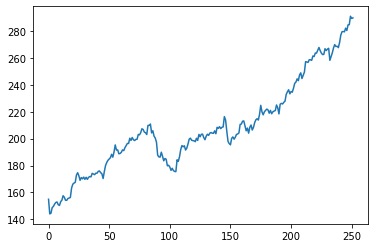

In [33]:
plt.plot(range(0,len(te_aapl.Open)),te_aapl.Open)

In [34]:
#Load test dataset
te_goog = pd.read_csv('GOOG_2019.csv')

In [35]:
te_goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900
...,...,...,...,...,...,...,...
246,2019-12-23,1355.869995,1359.800049,1346.510010,1348.839966,1348.839966,883100
247,2019-12-24,1348.500000,1350.260010,1342.780029,1343.560059,1343.560059,347500
248,2019-12-26,1346.170044,1361.327026,1344.469971,1360.400024,1360.400024,667500
249,2019-12-27,1362.989990,1364.530029,1349.310059,1351.890015,1351.890015,1038400


In [36]:
te_goog.Date = pd.to_datetime(te_goog.Date)

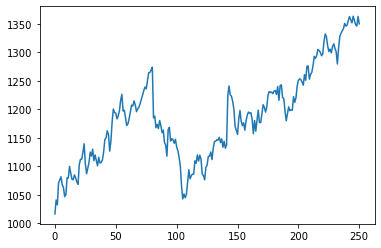

In [37]:
plt.plot(range(0,len( te_goog.Open)),  te_goog.Open)

In [57]:
env_test = TradingEnvironment(data_open=te_goog.Open, data_close = te_goog.Close, data2_open=te_aapl.Open, data2_close = te_aapl.Close, max_stride=1, series_length=len(te_goog.Close)-2)
env_test.reset()
state = env_test.reset()
reward = 0
done = False
msg = None
bought_goog_at = []
sold_goog_at = []
bg_action_times = []
sg_action_times = []
bought_aapl_at = []
sold_aapl_at = []
ba_action_times = []
sa_action_times = []
n_action_times = []
nothing_at = []
print('Starting Portfolio value :',env_test.portfolio_value().item())
while not done:
    action = model.act(state)
    if action == 0:
        bought_goog_at.append(te_goog.Open[env_test.cur_timestep])
        bg_action_times.append(env_test.cur_timestep)
    if action == 1:
        sold_goog_at.append(te_goog.Open[env_test.cur_timestep])
        sg_action_times.append(env_test.cur_timestep)
    if action == 2:
        nothing_at.append(1000)
        n_action_times.append(env_test.cur_timestep)
    if action == 3:
        bought_aapl_at.append(te_aapl.Open[env_test.cur_timestep])
        ba_action_times.append(env_test.cur_timestep)
    if action == 4:
        sold_aapl_at.append(te_aapl.Open[env_test.cur_timestep])
        sa_action_times.append(env_test.cur_timestep)
    
    state, reward, done, msg = env_test.step(action)
    model.rewards.append(reward)
if msg["msg"] == "done":
        print("Have {} goog, Have {} aapl and ${} cash. selling profit: {}, Total portfolio value: {}".format(state[0], state[1], state[2], env_test.profit, env_test.portfolio_value()))
    

Starting Portfolio value : 27636.400390625


C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Have 10.0 goog, Have 33.0 aapl and $17210.53125 cash. selling profit: 4716.723552999998, Total portfolio value: 32394.564453125


In [58]:
buy_date_g = [te_goog.Date[x] for x in bg_action_times]
sell_date_g = [te_goog.Date[x] for x in sg_action_times]
buy_date_a = [te_aapl.Date[x] for x in ba_action_times]
sell_date_a = [te_aapl.Date[x] for x in sa_action_times]

In [60]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x = te_goog.Date,y = te_goog.Open, mode="lines",showlegend=True,name="Goog_stock"),  row=1, col=1)
fig.add_trace(go.Scatter(x = buy_date_g,y = bought_goog_at, mode="markers",showlegend=True,name="Buy"),  row=1, col=1)
fig.add_trace(go.Scatter(x = sell_date_g,y = sold_goog_at, mode="markers",showlegend=True,name="Sell"),  row=1, col=1)
fig.add_trace(go.Scatter(x = te_aapl.Date,y = te_aapl.Open, mode="lines",showlegend=True,name="AAPL_stock"),  row=1, col=2)
fig.add_trace(go.Scatter(x = buy_date_a,y = bought_aapl_at, mode="markers",showlegend=True,name="Buy"),row=1, col=2)
fig.add_trace(go.Scatter(x = sell_date_a,y = sold_aapl_at, mode="markers",showlegend=True,name="Sell"),row=1, col=2)
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title="AC Test results on Goog and AAPL 2018 stock data with profit of " + str(env_test.profit.round()))
fig.show()